In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [6]:
df = pd.read_csv("/Users/meghanas/Downloads/insurance.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
median_charge = df["charges"].median()
df["high_cost"] = (df["charges"] > median_charge).astype(int)

print("Median charges:", median_charge)
df[["charges", "high_cost"]].head()

Median charges: 9382.033


,charges,high_cost
0,16884.92400,1
1,1725.55230,0
2,4449.46200,0
3,21984.47061,1
4,3866.85520,0


In [8]:
df_encoded = df.copy()
df_encoded["sex"] = LabelEncoder().fit_transform(df_encoded["sex"])
df_encoded["smoker"] = LabelEncoder().fit_transform(df_encoded["smoker"])
df_encoded = pd.get_dummies(df_encoded, columns=["region"], drop_first=True)

# Define X (features) and y (target)
X = df_encoded.drop(["charges", "high_cost"], axis=1)
y = df_encoded["high_cost"]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine (with probability for ROC)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

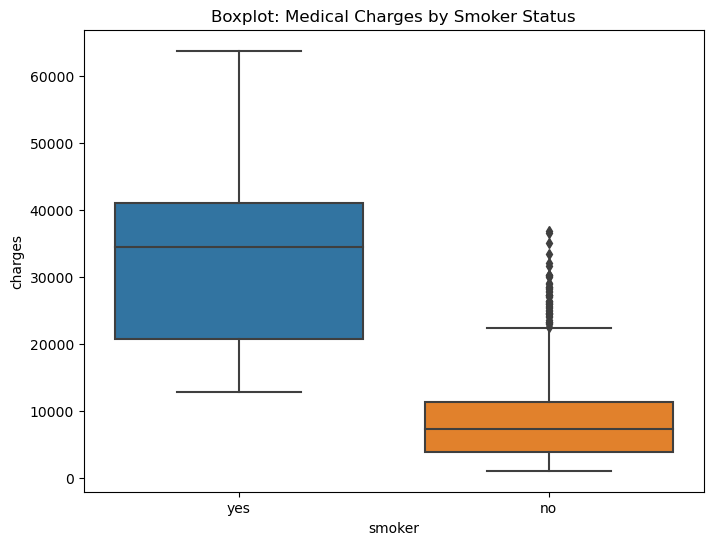

In [18]:
import seaborn as sns

# Boxplot: Charges by Smoker
plt.figure(figsize=(8,6))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Boxplot: Medical Charges by Smoker Status")
plt.show()


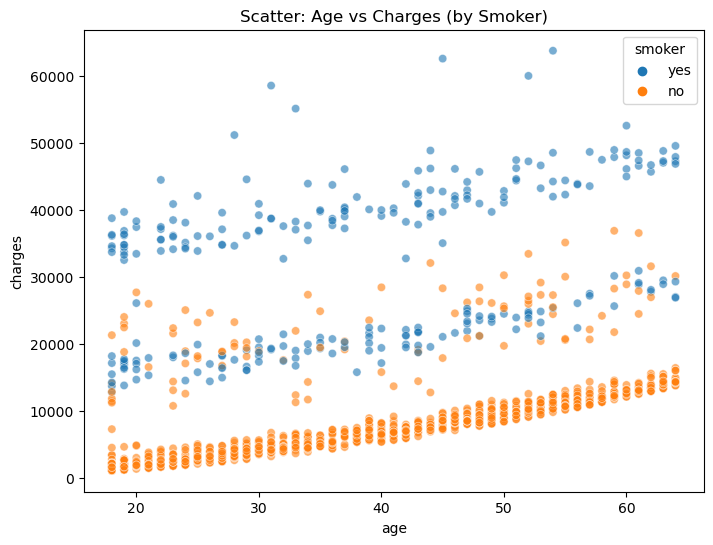

In [16]:
# Scatter: Age vs Charges (colored by smoker)
plt.figure(figsize=(8,6))
sns.scatterplot(x="age", y="charges", hue="smoker", data=df, alpha=0.6)
plt.title("Scatter: Age vs Charges (by Smoker)")
plt.show()

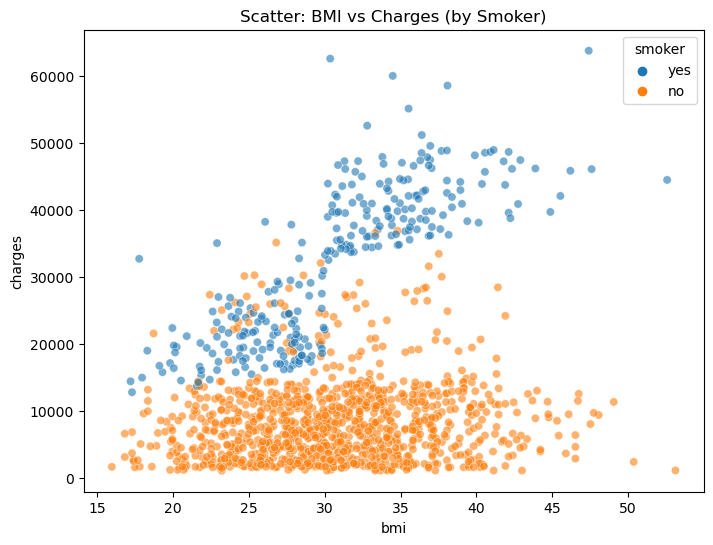

In [17]:
# Scatter: BMI vs Charges (colored by smoker)
plt.figure(figsize=(8,6))
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df, alpha=0.6)
plt.title("Scatter: BMI vs Charges (by Smoker)")
plt.show()

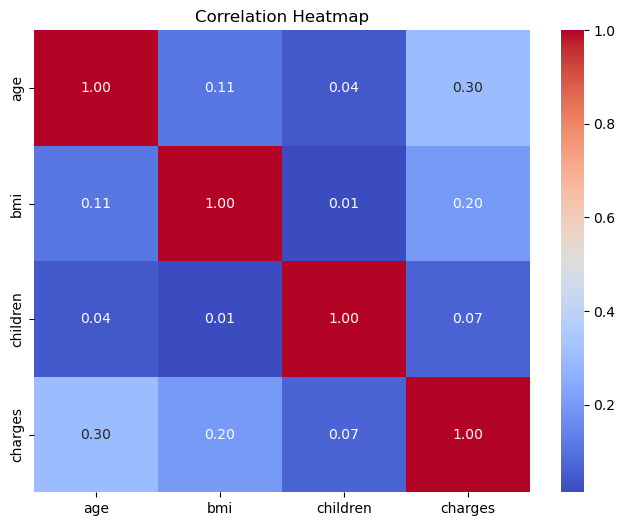

In [19]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df[["age", "bmi", "children", "charges"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


 Logistic Regression Results:
Accuracy: 0.899
Precision: 0.885
Recall: 0.918
F1 Score: 0.901


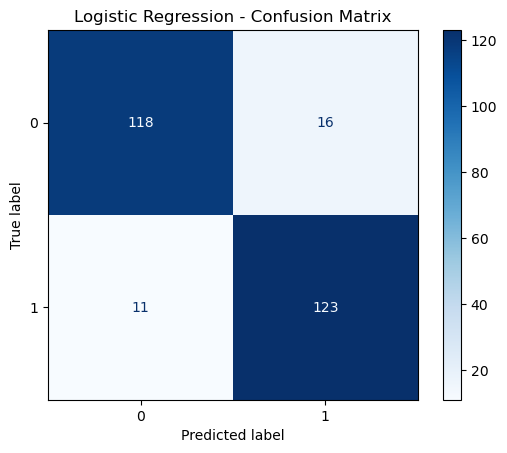


 Random Forest Results:
Accuracy: 0.940
Precision: 0.976
Recall: 0.903
F1 Score: 0.938


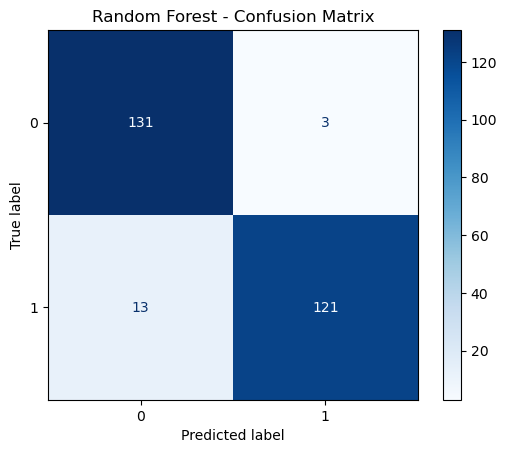


 SVM Results:
Accuracy: 0.922
Precision: 0.952
Recall: 0.888
F1 Score: 0.919


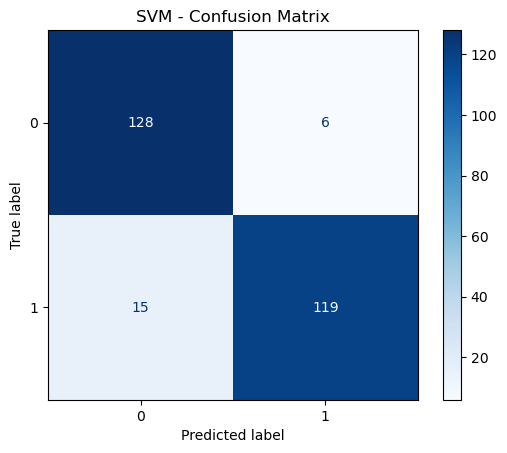

In [20]:
def evaluate_model(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n {model_name} Results:")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Evaluate all models
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, "SVM")



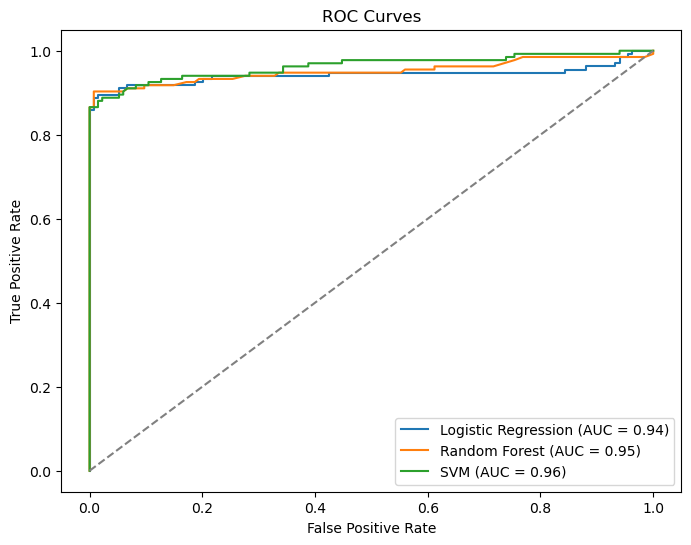

In [13]:
plt.figure(figsize=(8,6))

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "SVM": svm
}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

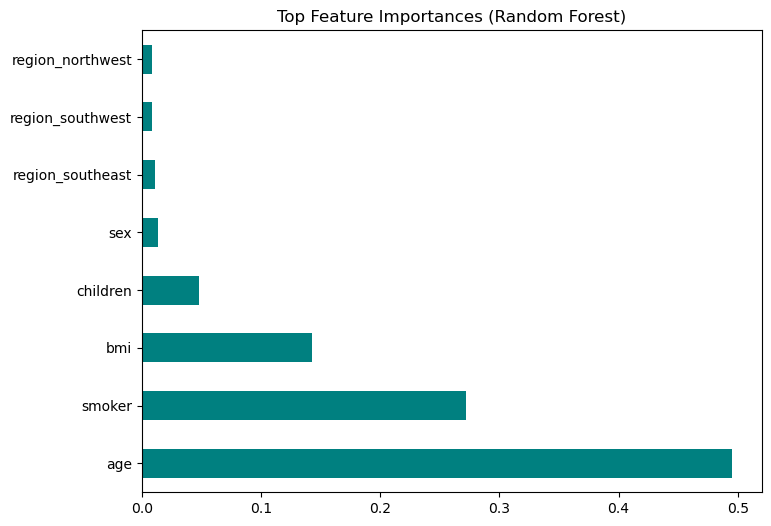

In [14]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6), color="teal")
plt.title("Top Feature Importances (Random Forest)")
plt.show()

Inisghts

- Smoking is the most critical driver of high insurance costs.

- Age and BMI steadily increase the likelihood of being high-cost.

- Children and Region have only minor influence.

- Random Forest outperforms simpler models because it captures nonlinear effects (e.g., smoking + high BMI).